https://drive.google.com/file/d/0B0ZXk88koS2KbDhXdWg1Q2RydlU/view
- 관심있는 토픽 중 한 가지를 선택해 데이터를 수집하여, Word2Vec모델을 만들고, 기존에 있던 ko.bin과 병합하여 새로운 한국어 Word2Vec 모델 만들기
- ex. 정치, 경제, 사회, 문화, 연예, 국제, 과학, 기술 // 게임, 영화, 한류 ,연예 등
- 데이터 수집 - 웹크롤링(기사, 위키, sns 외), 문헌, 소설 등

- 병합방법 : New_model.intersect_word2vec_format('ko.bin', binary=True)

#### Gensim 문법 변경
 - 모델 저장 : model.wv.save_word2vec_format("model.model", binary=False)
 - 모델 읽기 : gensim.models.Word2Vec.load("model.model", binary=False)
#### ko.bin 읽어온 후 binary=False로 모델 다시 저장
 - model_ko = gensim.models.Word2Vec.load('ko.bin')
 - model_ko.wv.save_word2vec_format("model_ko.model", binary=False)
#### 병합
 - file_name = 'model_ko.model'
 - model.intersect_word2vec_format(fname=file_name, lockf=0.0, binary=False, encoding='utf8', unicode_errors='ignore')

https://bumcrush.tistory.com/116 함수 참조

In [201]:
from bs4 import BeautifulSoup
from datetime import datetime
import requests
import pandas as pd
import re
'''''''''''''''''''''''''''''''''''''''''''''''''''''''''
< naver 뉴스 검색시 리스트 크롤링하는 프로그램 > _select사용
- 크롤링 해오는 것 : 링크,제목,신문사,날짜,내용요약본
- 날짜,내용요약본  -> 정제 작업 필요
- 리스트 -> 딕셔너리 -> df -> 엑셀로 저장 
'''''''''''''''''''''''''''''''''''''''''''''''''''''''''

#각 크롤링 결과 저장하기 위한 리스트 선언 
title_text=[]
link_text=[]
source_text=[]
date_text=[]
contents_text=[]
result={}

#엑셀로 저장하기 위한 변수
RESULT_PATH ='C:/Users/User/Desktop/python study/beautifulSoup_ws/crawling_result/'  #결과 저장할 경로
now = datetime.now() #파일이름 현 시간으로 저장하기

#날짜 정제화 함수
def date_cleansing(test):
    try:
        #지난 뉴스
        #머니투데이  10면1단  2018.11.05.  네이버뉴스   보내기  
        pattern = '\d+.(\d+).(\d+).'  #정규표현식 
    
        r = re.compile(pattern)
        match = r.search(test).group(0)  # 2018.11.05.
        date_text.append(match)
        
    except AttributeError:
        #최근 뉴스
        #이데일리  1시간 전  네이버뉴스   보내기  
        pattern = '\w* (\d\w*)'     #정규표현식 
        
        r = re.compile(pattern)
        match = r.search(test).group(1)
        #print(match)
        date_text.append(match)


#내용 정제화 함수 
def contents_cleansing(contents):
    first_cleansing_contents = re.sub('<dl>.*?</a> </div> </dd> <dd>', '', 
                                      str(contents)).strip()  #앞에 필요없는 부분 제거
    second_cleansing_contents = re.sub('<ul class="relation_lst">.*?</dd>', '', 
                                       first_cleansing_contents).strip()#뒤에 필요없는 부분 제거 (새끼 기사)
    third_cleansing_contents = re.sub('<.+?>', '', second_cleansing_contents).strip()
    contents_text.append(third_cleansing_contents)
    #print(contents_text)
    

def crawler(maxpage,query,sort,s_date,e_date):

    s_from = s_date.replace(".","")
    e_to = e_date.replace(".","")
    page = 1  
    maxpage_t =(int(maxpage)-1)*10+1   # 11= 2페이지 21=3페이지 31=4페이지  ...81=9페이지 , 91=10페이지, 101=11페이지
    
    while page <= maxpage_t:
        url = "https://search.naver.com/search.naver?where=news&query=" + query + "&sort="+sort+"&ds=" + s_date + "&de=" + e_date + "&nso=so%3Ar%2Cp%3Afrom" + s_from + "to" + e_to + "%2Ca%3A&start=" + str(page)
        
        response = requests.get(url)
        html = response.text
 
        #뷰티풀소프의 인자값 지정
        soup = BeautifulSoup(html, 'html.parser')
 
        #<a>태그에서 제목과 링크주소 추출
        atags = soup.select('._sp_each_title')
        for atag in atags:
            title_text.append(atag.text)     #제목
            link_text.append(atag['href'])   #링크주소
            
        #신문사 추출
        source_lists = soup.select('._sp_each_source')
        for source_list in source_lists:
            source_text.append(source_list.text)    #신문사
        
        #날짜 추출 
        date_lists = soup.select('.txt_inline')
        for date_list in date_lists:
            test=date_list.text   
            date_cleansing(test)  #날짜 정제 함수사용 
        
        #본문요약본
        contents_lists = soup.select('ul.type01 dl')
        for contents_list in contents_lists:
            #print('==='*40)
            #print(contents_list)
            contents_cleansing(contents_list) #본문요약 정제화
        
        
        #모든 리스트 딕셔너리형태로 저장
        result= {"date" : date_text , "title":title_text ,  "source" : source_text ,"contents": contents_text ,"link":link_text }  
        print(page)
        
        df = pd.DataFrame(result)  #df로 변환
        page += 10
    
    
    # 새로 만들 파일이름 지정
    outputFileName = '%s-%s-%s  %s시 %s분 %s초 merging.xlsx' % (now.year, now.month, now.day, now.hour, now.minute, now.second)
    return df['contents'] 
    

def main():
    info_main = input("="*50+"\n"+"입력 형식에 맞게 입력해주세요."+"\n"+" 시작하시려면 Enter를 눌러주세요."+"\n"+"="*50)
    
    maxpage = input("최대 크롤링할 페이지 수 입력하시오: ")  
    query = input("검색어 입력: ")  
    sort = input("뉴스 검색 방식 입력(관련도순=0  최신순=1  오래된순=2): ")    #관련도순=0  최신순=1  오래된순=2
    s_date = input("시작날짜 입력(2019.01.04):")  #2019.01.04
    e_date = input("끝날짜 입력(2019.01.05):")   #2019.01.05
    
    df2=crawler(maxpage,query,sort,s_date,e_date) 
    return df2
df2=main()

입력 형식에 맞게 입력해주세요.
 시작하시려면 Enter를 눌러주세요.
최대 크롤링할 페이지 수 입력하시오: 5
검색어 입력: 스포츠
뉴스 검색 방식 입력(관련도순=0  최신순=1  오래된순=2): 0
시작날짜 입력(2019.01.04):
끝날짜 입력(2019.01.05):
1
11
21
31
41


In [202]:
df2

0     야구나 농구 등 스포츠를 좋아하는 어린이팬들은 구단 로고가 찍혀있는 모자를 즐겨 쓰...
1     등 스포츠 팬들 가운데 응원하는 팀의 유니폼이나 모자 같은 '굿즈'를 가진 분들이 ...
2     락스게이밍이 주최, 주관하고 한화생명, 부산정보산업진흥원, 한국e스포츠협회, 커세어...
3     이번 주말 서울광장에서 국제치어리딩스포츠대회가 펼쳐진다. 서울시는 아시아대학스포츠연...
4     국제치어리딩스포츠대회가 휴일 동안 서울시청 앞 서울광장에서 펼쳐집니다. 서울시는 내...
5     렉스턴 스포츠 32대를 전달했다고 22일 밝혔다. 하이웨이즈 잉글랜드는 영국의 고속...
6     미국스포츠의학회지(AJSM; American Journal of Sports Med...
7     올해부터 e스포츠 정식 종목으로 승격한 한빛소프트의 오디션이 지역 e스포츠 축제에 ...
8     지어진 '한림 스포츠클라이밍 경기장'이 오는 9월 개장 운영된다. 제주시에서는 읍....
9     부산광역시(시장 오거돈)가 주최하고 부산정보산업진흥원(원장 이인숙)이 주관하는 제2...
10    트럼프 대통령은 밥 쿠지를 가리켜 "농구뿐 아니라 스포츠 역사상 가장 위대한 인물 ...
11    미국스포츠의학회지(AJSM; American Journal of Sports Med...
12    e스포츠 대회를 실시한다. 스마일게이트는 지난 1일 ‘CFS 인비테이셔널 브라질 2...
13    환경부 산하 국립공원공단(이사장 권경업)은 22일 서울 마포구 북한산스마트워크센터에...
14    한빛소프트의 PC 온라인 리듬댄스 게임 '오디션'이 지역 e스포츠 축제에 적극 참가...
15    지어진 '한림 스포츠클라이밍 경기장'이 오는 9월 개장 운영된다. 제주시에서는 읍....
16    부산광역시(시장 오거돈)가 주최하고 부산정보산업진흥원(원장 이인숙)이 주관하는 제2...
17    그런데 오늘 민관 합동 기구인 스포츠 혁신위원회가 이 올림픽위원회를 체육회로

In [204]:
pd.DataFrame(df2).to_csv('contents2222.csv',encoding='utf8')

In [3]:
contents=pd.read_csv('contents2.csv',encoding='utf-8',usecols=['contents'])

In [5]:
import gensim

In [6]:
import nltk

In [7]:
from konlpy.tag import Okt
okt=Okt()

C:\ProgramData\Anaconda3\envs\insun\lib\site-packages\jpype\_core.py:210: UserWarning: 
-------------------------------------------------------------------------------
Deprecated: convertStrings was not specified when starting the JVM. The default
behavior in JPype will be False starting in JPype 0.8. The recommended setting
for new code is convertStrings=False.  The legacy value of True was assumed for
this session. If you are a user of an application that reported this warning,
please file a ticket with the developer.
-------------------------------------------------------------------------------

  """)


In [8]:
contents.to_csv('contents2.csv', encoding='utf-8')

In [9]:
import re

In [11]:
contents2=[re.sub('[^\w ]', '', i) for i in list(contents.dropna()['contents'])]

In [13]:
result_c=[]
for i in contents2 :
    tokenlist = okt.pos(i,stem=True,norm=True)
    temp = []
    for word in tokenlist :
        if word[1] in ["Noun"] :
            temp.append((word[0]))
    if temp :
        result_c.append(temp)


In [210]:
print(len(result_c))

9997
142


In [169]:
#불용어 제거하기
stopwords='''이	VCP	0.018279601
있	VA	0.011699048
하	VV	0.009773658
것	NNB	0.00973315
들	XSN	0.00689824
그	MM	0.005327252
되	VV	0.00361335
수	NNB	0.003473622
이	NP	0.003361203
보	VX	0.003310379
않	VX	0.0029757
없	VA	0.002920476
나	NP	0.002690479
사람	NNG	0.002073917
주	VV	0.001884579
아니	VCN	0.001870774
등	NNB	0.001822074
같	VA	0.001724522
우리	NP	0.001714509
때	NNG	0.001685684
년	NNB	0.001647755
가	VV	0.001618626
한	MM	0.001584036
지	VX	0.001537763
대하	VV	0.00150378
오	VV	0.001490884
말	NNG	0.001321876
일	NNG	0.001239799
그렇	VA	0.001232062
위하	VV	0.001170618
때문	NNB	0.001146647
그것	NP	0.001099161
두	VV	0.001063053
말하	VV	0.001030587
알	VV	0.000995693
그러나	MAJ	0.000978246
받	VV	0.000924084
못하	VX	0.000904665
일	NNB	0.000880239
그런	MM	0.000879481
또	MAG	0.000870985
문제	NNG	0.000823954
더	MAG	0.000801652
사회	NNG	0.000793459
많	VA	0.000789211
그리고	MAJ	0.000779653
좋	VA	0.000763723
크	VA	0.000758565
따르	VV	0.000738084
중	NNB	0.000733229
나오	VV	0.000725188
가지	VV	0.000720485
씨	NNB	0.000710169
시키	XSV	0.000707893
만들	VV	0.000703797
지금	NNG	0.000699701
생각하	VV	0.000694846
그러	VV	0.000692418
속	NNG	0.00068544
하나	NR	0.000655097
집	NNG	0.000648573
살	VV	0.000648422
모르	VV	0.000645084
적	XSN	0.000643112
월	NNB	0.000639319
데	NNB	0.000636436
자신	NNG	0.000632188
안	MAG	0.000625968
어떤	MM	0.000623237
내	NP	0.000622023
내	VV	0.000614438
경우	NNG	0.000613831
명	NNB	0.00061019
생각	NNG	0.000587433
시간	NNG	0.00057302
그녀	NP	0.000571806
다시	MAG	0.00055618
이런	MM	0.000550263
앞	NNG	0.000548898
보이	VV	0.000542678
번	NNB	0.000542526
나	VX	0.000538126
다른	MM	0.000536306
어떻	VA	0.000533423
여자	NNG	0.000531754
개	NNB	0.000530085
전	NNG	0.00052872
들	VV	0.000514914
사실	NNG	0.000511728
이렇	VA	0.000511576
점	NNG	0.000507935
싶	VX	0.000504749
말	VX	0.000503991
정도	NNG	0.000496102
좀	MAG	0.000492916
원	NNB	0.000492309
잘	MAG	0.000491399
통하	VV	0.000486847
소리	NNG	0.000485633
놓	VX	0.000482751
'''.split()[::3]

In [170]:
result_c_new=[]
for i in result_c :
    temp=[]
    for j in i :
        if j not in stopwords :
            temp.append(j)
    result_c_new.append(temp)

In [190]:
from gensim.models import Word2Vec

In [191]:
model2 = Word2Vec(result_c_new, size=200, window=5, min_count=3, workers=4,sg=0)

In [192]:
#model2.model로 저장
model2.wv.save_word2vec_format('model2.model',binary=False)

C:\ProgramData\Anaconda3\envs\insun\lib\site-packages\smart_open\smart_open_lib.py:398: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL


In [193]:
#ko.bin 불러오기
model_ko = gensim.models.Word2Vec.load('./ko/ko.bin')

C:\ProgramData\Anaconda3\envs\insun\lib\site-packages\smart_open\smart_open_lib.py:398: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL


In [194]:
#ko.bin 다시 binary=False로 저장
model_ko.wv.save_word2vec_format("model_ko.model", binary=False)

In [180]:
#ko.bin 사용 목적
file_name2 = 'model_ko.model'

In [195]:
#model2 + model_ko.model 합치기 (교집합 )
model2.intersect_word2vec_format(fname=file_name2, lockf=0.0, binary=False, encoding='utf8', unicode_errors='ignore') 

In [196]:
#합친 모델 저장
model2.wv.save_word2vec_format('model2_final.model', binary=False)

In [197]:
for i in ['축구','배구','야구','프로야구','스포츠','골프','수영','생중계', '축구선수', '선수', '올림픽', '대회', '게임'] :
    print(i)
    for j in model2.wv.most_similar(i) :
        print(j)
    print('\n')

축구
('배구', 0.7272718548774719)
('농구', 0.680548906326294)
('야구', 0.6605638861656189)
('테니스', 0.6392971277236938)
('골프', 0.6258326768875122)
('하키', 0.6254591941833496)
('탁구', 0.6215586066246033)
('복싱', 0.6215360760688782)
('핸드볼', 0.6086555123329163)
('풋볼', 0.6044343709945679)


배구
('농구', 0.8551924228668213)
('탁구', 0.8331664204597473)
('핸드볼', 0.8295367360115051)
('복싱', 0.7764195203781128)
('양궁', 0.7742055654525757)
('배드민턴', 0.7517027258872986)
('테니스', 0.7504335045814514)
('축구', 0.7272718548774719)
('펜싱', 0.7231592535972595)
('골프', 0.7187362313270569)


야구
('농구', 0.7576812505722046)
('배구', 0.7134213447570801)
('축구', 0.6605639457702637)
('레슬링', 0.6470624804496765)
('야구단', 0.6240009665489197)
('복싱', 0.6128005981445312)
('씨름', 0.5838602781295776)
('골프', 0.5824359655380249)
('탁구', 0.5720633268356323)
('핸드볼', 0.5610301494598389)


프로야구
('지속가능성', 0.8751778602600098)
('식비', 0.8660119771957397)
('소셜', 0.865458607673645)
('선제골', 0.8637300729751587)
('생중계', 0.8611466884613037)
('동기부여', 0.856515467166

In [198]:
model2.wv.vocab.keys()

dict_keys(['야구', '농구', '스포츠', '어린이', '팬', '구단', '로고', '모자', '프로스포츠', '일부', '제품', '물질', '검', '주의', '소비자원', '조사', '결과', '미국', '의학', '회지', '의', '편집', '위원', '선정', '은', '세계', '권위', '학술지', '정형외과', '및', '임', '널', '영향력', '가장', '문화', '체육관', '광부', '혁신', '위원회', '서울시', '종로구', '정부', '서울', '청사', '브리핑', '체육회', '분리', '권고', '지난', '출범', '체육', '여러', '대해', '변화', '위', '렉', '스턴', '전달', '하이', '웨이즈', '잉글랜드', '영국', '고속도로', '주요', '도로', '운영', '유지', '보수', '담당', '기관', '이번', '공급', '관리', '용', '차량', '활용', '닉', '해리스', '부산광역시', '시장', '오거돈', '주최', '부산', '정보산업', '진흥', '원장', '이인숙', '주관', '제', '전국', '직장인', '대회', '양일간', '부산진구', '위치', '방', '개최', '행사', '통해', '한빛소프트', '온라인', '리듬', '댄스', '게임', '오디션', '지역', '축제', '적극', '참가', '확산', '페스티벌', '참여', '개발', '서비스', '한림', '밍', '경기장', '개장', '제주시', '읍', '날로', '증가', '생활', '수요', '대처', '민', '호인', '레저', '공간', '마련', '해양스포츠', '전이', '경기', '시흥', '안산', '화성시', '일원', '성황리', '올해', '최초', '수도권', '시화호', '해양', '물결', '주제', '제전', '발암', '한국', '제공', '그린', '포스트', '코리아', '프로야구', '프로축구', '프로농구', '인기', '관련', '굿',

https://programmers.co.kr/learn/courses/21/lessons/1698 참조

In [186]:
from sklearn.manifold import TSNE
import matplotlib as mpl
import matplotlib.pyplot as plt
import gensim 
import gensim.models as g

# 그래프에서 마이너스 폰트 깨지는 문제에 대한 대처
mpl.rcParams['axes.unicode_minus'] = False

model = model22
vocab = list(model.wv.vocab)
X = model[vocab]

print(len(X))
print(X[0][:10])
tsne = TSNE(n_components=2)

# 100개의 단어에 대해서만 시각화
X_tsne = tsne.fit_transform(X[:100,:])
# X_tsne = tsne.fit_transform(X)

3831
[ 1.3882519   1.6967498   1.0339427   0.4724479  -0.43555894  0.5456307
  0.734138   -0.88695043 -1.37729     2.1651583 ]


C:\ProgramData\Anaconda3\envs\insun\lib\site-packages\ipykernel_launcher.py:12: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  if sys.path[0] == '':


In [187]:
df = pd.DataFrame(X_tsne, index=vocab[:100], columns=['x', 'y'])
df.shape

(100, 2)

In [188]:
df.head()

,x,y
야구,-26.121006,-84.138741
농구,-18.803915,-72.489525
스포츠,-3.070975,-76.106354
어린이,17.562113,-44.331924
팬,17.859087,-92.818199


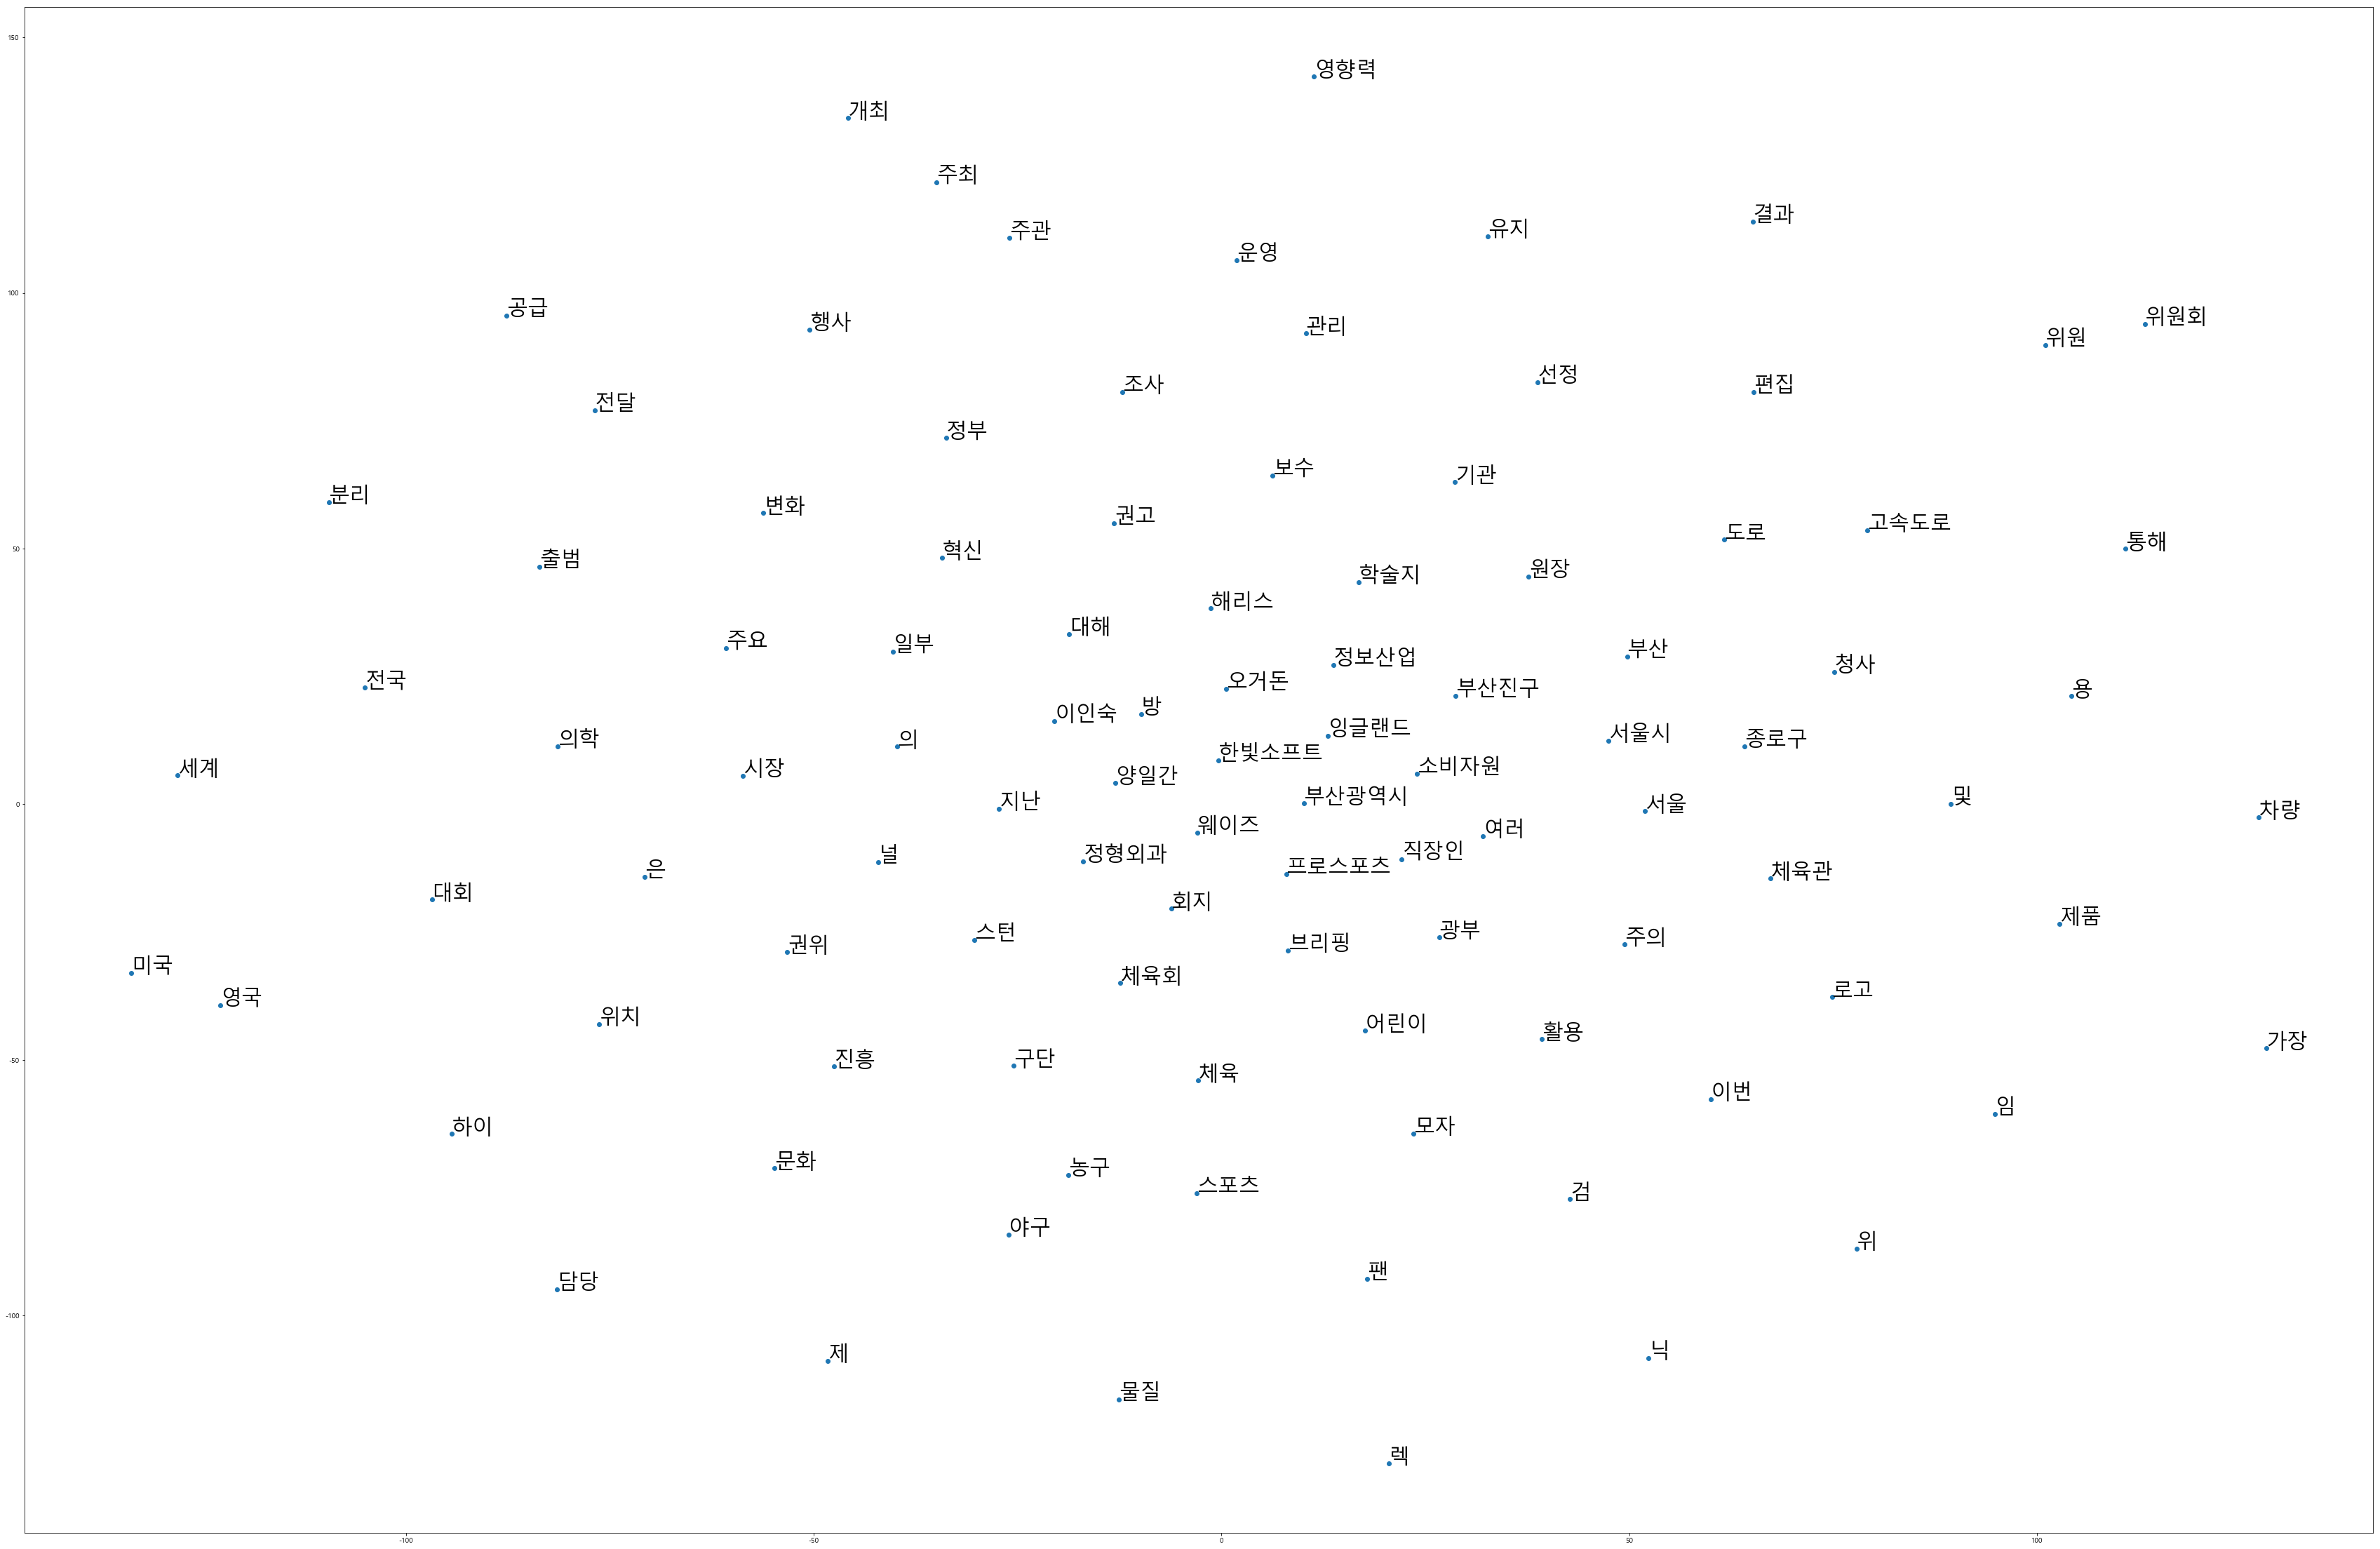

In [189]:
fig = plt.figure()
fig.set_size_inches(60, 40)
ax = fig.add_subplot(1, 1, 1)

ax.scatter(df['x'], df['y'])

for word, pos in df.iterrows():
    ax.annotate(word, pos, fontsize=30)
plt.show()